<a href="https://colab.research.google.com/github/Bionerdess/NMA2021/blob/ALedits/NMA2021_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2021
### Collaborative Project analyzing data by Steinmetz et. al., 2019
By Anna-Lena Schlenner, Shira Lupkin, Katrina Lee Bartas and Joaquin Herrero

In [1]:
#@title Necesssary imports
from scipy import stats, io
import numpy as np
import os, requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid',rc={'grid.linewidth': 2})

from matplotlib import rcParams 
from sklearn.decomposition import PCA
import pandas as pd
import pickle

In [2]:
#@title Data loading
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [3]:
#@title Retrieve relevant data

vis_ses=[]

for s in range(len(alldat)):
  dat=alldat[s]
  if 'VISp' in dat['brain_area']:
    vis_ses.append(s)

alldat = alldat[vis_ses]

variables = [['spks'],['brain_area'],['reaction_time'],['response_time'], 
             ['response'],['contrast_left'],['contrast_right'],['feedback_type'],['bin_size']]
dd = np.array([])

for s in range(alldat.shape[0]):

  newdat = dict()
  dat = alldat[s]

  for key in dat:
    if  np.isin(key,variables):
      newdat[key] = dat[key]
  dd = np.hstack((dd,newdat))

print('Number of sessions with VISp recordings: {}'.format(dd.shape[0]))

Number of sessions with VISp recordings: 12


In [4]:
#@title Extract VISp FR for each contrast level
visDat00 = np.empty((dd.shape[0],250))
visDat25 = np.empty((dd.shape[0],250))
visDat05 = np.empty((dd.shape[0],250))
visDat1 = np.empty((dd.shape[0],250))

for s in range(dd.shape[0]):
  roi = dd[s]['brain_area']
  spks = dd[s]['spks'][roi=='VISp']
  contrast_right = dd[s]['contrast_right']
  visDat00[s] = spks[:,contrast_right==0.0,:].mean(axis=(0,1))
  visDat25[s] = spks[:,contrast_right==0.25,:].mean(axis=(0,1))
  visDat05[s] = spks[:,contrast_right==0.5,:].mean(axis=(0,1))
  visDat1[s] = spks[:,contrast_right==1.0,:].mean(axis=(0,1))


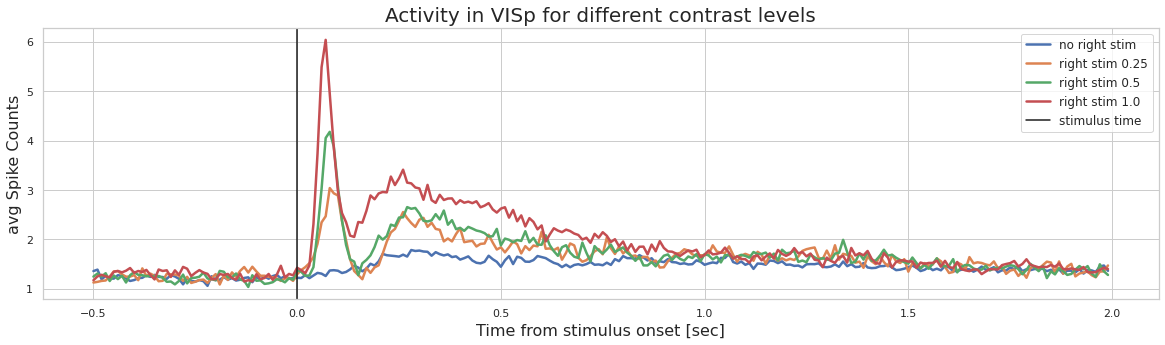

In [5]:
#@title Plot VISp across contrast levels

# can add shaded SEM around each contrast line
addSEM = 0

if addSEM==1:
  semVis = np.empty((4,250))
  semVis[0] = 1/bins * (np.std(visDat00,axis=0)/np.sqrt(visDat00.shape[0]))
  semVis[1] = 1/bins * (np.std(visDat25,axis=0)/np.sqrt(visDat25.shape[0]))
  semVis[2] = 1/bins * (np.std(visDat05,axis=0)/np.sqrt(visDat05.shape[0]))
  semVis[3] = 1/bins * (np.std(visDat1,axis=0)/np.sqrt(visDat1.shape[0]))

bins = dd[0]['bin_size']
x = np.arange(-.5,2.0,bins)
meanVis = np.empty((4,250))

meanVis[0] = 1/bins * visDat00.mean(axis=0)
meanVis[1] = 1/bins * visDat25.mean(axis=0)
meanVis[2] = 1/bins * visDat05.mean(axis=0)
meanVis[3] = 1/bins * visDat1.mean(axis=0)

plt.figure(figsize=(20,5))
plt.plot(x,meanVis[0],linewidth=2.5)
plt.plot(x,meanVis[1],linewidth=2.5)
plt.plot(x,meanVis[2],linewidth=2.5)
plt.plot(x,meanVis[3],linewidth=2.5)

if addSEM==1:
  plt.fill_between(x,meanVis[0]-semVis[0],meanVis[0]+semVis[0],alpha=0.3)
  plt.fill_between(x,meanVis[1]-semVis[1],meanVis[1]+semVis[1],alpha=0.3)
  plt.fill_between(x,meanVis[2]-semVis[2],meanVis[2]+semVis[2],alpha=0.3)
  plt.fill_between(x,meanVis[3]-semVis[3],meanVis[3]+semVis[3],alpha=0.3)

plt.axvline(0,color='k')
plt.legend(['no right stim','right stim 0.25','right stim 0.5','right stim 1.0', 'stimulus time'], fontsize=12)
plt.xlabel('Time from stimulus onset [sec]',size=16)
plt.ylabel('avg Spike Counts',size=16)
plt.title('Activity in VISp for different contrast levels',size=20)
plt.show()

In [7]:
df = np.concatenate([visDat00,visDat25,visDat05,visDat1])

nSess = dd.shape[0]
nContrast = int(df.shape[0]/nSess)

contrast = np.zeros((int(nSess*nContrast),1))
for i in range(1,nContrast):
  contrast[i*nSess:i*nSess+nSess] = i


In [8]:
#@title Run PCA

pca = PCA(n_components=4)

PC = pca.fit_transform(df)

pdPC =pd.DataFrame(PC,columns=['PC1','PC2','PC3','PC4'])
pdPC['contrast'] = contrast
pdPC['contrast'] = pdPC['contrast'].map({0.0: 0.0,1.0: 0.25,2.0: 0.5,3.0: 1.0})



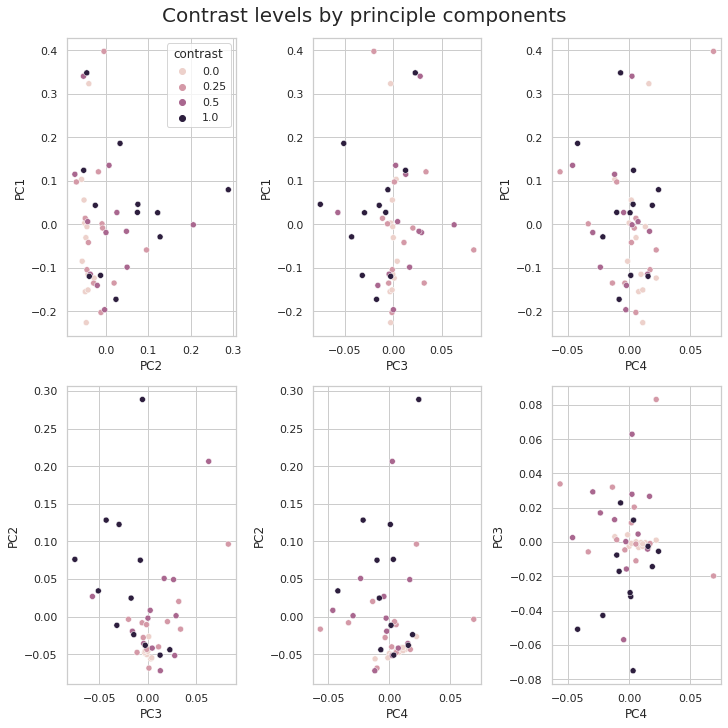

In [10]:
fig, axes = plt.subplots(2,3,figsize=(10,10),constrained_layout=True) # ,figsize=(40,40)
fig.suptitle('Contrast levels by principle components',size=20)
sns.scatterplot(data = pdPC,x='PC2',y='PC1',ax=axes[0,0],hue=pdPC['contrast'],legend='full') # 
sns.scatterplot(data = pdPC,x='PC3',y='PC1',ax=axes[0,1],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC4',y='PC1',ax=axes[0,2],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC3',y='PC2',ax=axes[1,0],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC4',y='PC2',ax=axes[1,1],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC4',y='PC3',ax=axes[1,2],hue=pdPC['contrast'],legend=False)
